In [1]:
# Python ≥3.5 is required
import sys

import keras.datasets.mnist

print("Python: ", sys.version_info)
assert sys.version_info >= (3, 7)

# Scikit-Learn ≥0.20 is required
import sklearn
print("sklearn version: ", sklearn.__version__)
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.8 is required
import tensorflow as tf
print("TF version: ", tf.__version__)
# assert tf.__version__ >= "2.8"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

# Common imports
import numpy as np
import os
import pandas as pd
import tensorflow_datasets as tfds
from tensorflow_datasets.core.utils import gcs_utils
gcs_utils._is_gcs_disabled = True
from tensorflow import keras


# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

2024-06-06 23:55:25.325249: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 23:55:25.325302: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 23:55:25.375088: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-06 23:55:25.477590: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 23:55:26.618766: W tensorflow/compiler/tf2

Python:  sys.version_info(major=3, minor=9, micro=19, releaselevel='final', serial=0)
sklearn version:  1.4.1.post1
TF version:  2.15.0


2024-06-06 23:55:27.785035: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 23:55:27.965292: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 23:55:27.965340: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 23:55:27.969448: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 23:55:27.969509: I external/local_xla/xla/stream_executor

GPU installed:  True
1 Physical GPUs, 1 Logical GPUs


In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    savefig = plt.savefig(path, format=fig_extension, dpi=resolution)

In [26]:
! pip install --upgrade tfds-nightly

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


## get the data(EMNIST)

In [3]:
import tensorflow_datasets as tfds

(train_data, valid_data, test_data), info = tfds.load("emnist/byclass", split=["train[:80%]", "train[80%:]", "test"], as_supervised=True, with_info=True)

In [4]:
print(f"size of train: {train_data.cardinality().numpy()}")
print(f"size of validation: {valid_data.cardinality().numpy()}")
print(f"size of test: {test_data.cardinality().numpy()}")

size of train: 558346
size of validation: 139586
size of test: 116323


In [5]:
num_class = info.features["label"].num_classes
print(num_class)

62


## prepare the data

In [6]:
def preprocess_resnet50(image, label):
    # Resize image to (32, 32, 1)
    image = tf.image.resize(image, size=(32, 32))
    # Convert grayscale to RGB by duplicating the single channel
    image = tf.image.grayscale_to_rgb(image)
    # Rescale pixel values to [0, 1]
    image = tf.cast(image, tf.float64) / 255.0
    return image, label

In [7]:
train_data = train_data.map(preprocess_resnet50)
valid_data = valid_data.map(preprocess_resnet50)
test_data = test_data.map(preprocess_resnet50)

In [8]:
batch_size = 32
train_data = train_data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_data = valid_data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

## train / evaluate ResNet50

### callbacks

In [9]:

# early stopping
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,
                                                     restore_best_weights=True,verbose=1)

# checkpoint for tensorboard
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("resNet50_checkpoint",
                                                         save_best_only=True)
run_index = 1 # 모델을 훈련할 때마다 증가합니다.
run_logdir = Path() / "resNet50Log" / f"run_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb]

In [34]:
# %load_ext tensorboard
# %tensorboard --logdir=./resNet50Log

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

In [10]:
resNet = tf.keras.applications.ResNet50(classes=num_class, weights=None, input_shape=(32,32,3), include_top=False)
resNetv2 = tf.keras.applications.ResNet50V2(classes=num_class, weights=None, input_shape=(32,32,3))

resNetv2.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 18, 18, 64)           0         ['conv1_conv[0][0]']          
                                                                                         

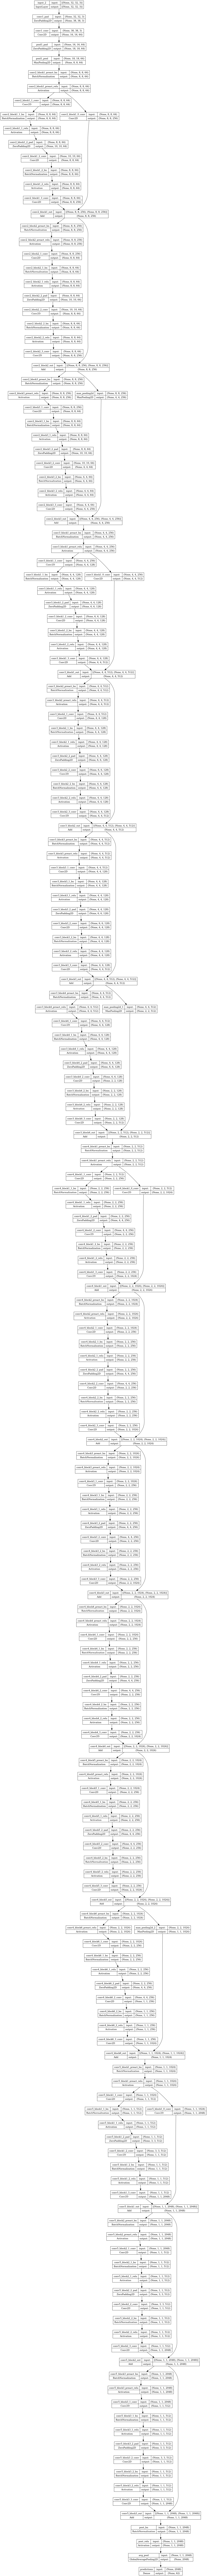

In [11]:
tf.keras.utils.plot_model(resNetv2, "resNetv2.png", show_shapes=True)

In [10]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, weight_decay=0.0001, momentum=0.9)

논문 내용 참조함

[transfer learning](https://keras.io/guides/transfer_learning/) 참고

In [15]:
resNetv2.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics='accuracy')

In [16]:
history = resNetv2.fit(train_data, epochs=10, validation_data=valid_data, batch_size=128, callbacks=callbacks, use_multiprocessing=True, workers=6,validation_steps=10)

Epoch 1/10


2024-05-20 20:52:47.471514: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-05-20 20:52:50.973200: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2e59cd15c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-20 20:52:50.973230: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
I0000 00:00:1716205971.012990   38909 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17449/17449 [==============================] - 836s 47ms/step - loss: 0.8317 - accuracy: 0.7419 - val_loss: 0.5752 - val_accuracy: 0.7875
Epoch 2/10
17449/17449 [==============================] - 792s 45ms/step - loss: 0.4961 - accuracy: 0.8250 - val_loss: 0.4907 - val_accuracy: 0.8156
Epoch 3/10
17449/17449 [==============================] - 798s 46ms/step - loss: 0.4639 - accuracy: 0.8344 - val_loss: 0.4746 - val_accuracy: 0.8250
Epoch 4/10
17449/17449 [==============================] - 814s 47ms/step - loss: 0.4358 - accuracy: 0.8419 - val_loss: 0.5226 - val_accuracy: 0.8188
Epoch 5/10
17449/17449 [==============================] - 823s 47ms/step - loss: 0.4130 - accuracy: 0.8488 - val_loss: 0.4965 - val_accuracy: 0.8313
Epoch 5: early stopping


(224,224,3) 으로 진행하니 epoch 당 40분이 걸림...
대신 최소 사이즈인 (32,32,3) 으로 진행해봄 -> 14분으로 (일단은) 개선됨

In [16]:
# redefine early stopping
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,
                                                     restore_best_weights=True,verbose=1)

callbacks = [early_stopping_cb]

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, weight_decay=0.0001, momentum=0.9)


좀 일찍 멈추는 감이 있어서 `patience` 값을 10으로 증가시킴
나머지는 그대로 유지

In [17]:
resNetv2_1 = tf.keras.applications.ResNet50V2(classes=num_class, weights=None, input_shape=(32,32,3))

resNetv2_1.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics='accuracy')

history_1 = resNetv2_1.fit(train_data, epochs=100, validation_data=valid_data, batch_size=128, callbacks=callbacks)

Epoch 1/100
17449/17449 [==============================] - 841s 48ms/step - loss: 0.8602 - accuracy: 0.7366 - val_loss: 0.6191 - val_accuracy: 0.8008
Epoch 2/100
17449/17449 [==============================] - 841s 48ms/step - loss: 0.5394 - accuracy: 0.8121 - val_loss: 0.5956 - val_accuracy: 0.8097
Epoch 3/100
17449/17449 [==============================] - 846s 48ms/step - loss: 0.5210 - accuracy: 0.8189 - val_loss: 0.4975 - val_accuracy: 0.8218
Epoch 4/100
17449/17449 [==============================] - 841s 48ms/step - loss: 0.4880 - accuracy: 0.8275 - val_loss: 0.4401 - val_accuracy: 0.8407
Epoch 5/100
17449/17449 [==============================] - 33247s 2s/step - loss: 0.4666 - accuracy: 0.8336 - val_loss: 0.4088 - val_accuracy: 0.8486
Epoch 6/100
17449/17449 [==============================] - 850s 49ms/step - loss: 0.4722 - accuracy: 0.8321 - val_loss: 0.4932 - val_accuracy: 0.8260
Epoch 7/100
17449/17449 [==============================] - 1086s 62ms/step - loss: 0.4430 - accuracy

문제점:
- 너무 오래 걸림: epoch 당 800s 이면 멀 실험하기도 어려움
- 모델 자체가 keras에 있는 내용을 그대로 들고 온 거라 layer나 optimizer / activation function 등을 조작할 수가 없음

-> 자체적인 ResNet을 개발

### building custom(lighter) ResNet model

In [27]:
# light ResNet model1

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def res_block(x, filters, kernel_size=3, stride=1):
    y = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    
    y = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(y)
    y = BatchNormalization()(y)
    
    if stride != 1 or x.shape[-1] != filters:
        x = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x)
    
    out = Add()([x, y])
    out = Activation('relu')(out)
    return out

def build_light_resnet50(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(16, (3, 3), padding='same', strides=1)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = res_block(x, 16, stride=1)
    x = res_block(x, 16, stride=1)
    
    x = res_block(x, 32, stride=2)
    x = res_block(x, 32, stride=1)
    
    x = res_block(x, 64, stride=2)
    x = res_block(x, 64, stride=1)
    
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

input_shape = (32, 32, 3)
num_classes = 62
light_resnet = build_light_resnet50(input_shape, num_classes)
light_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 16)           448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 16)           64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 32, 32, 16)           0         ['batch_normalization[0][0

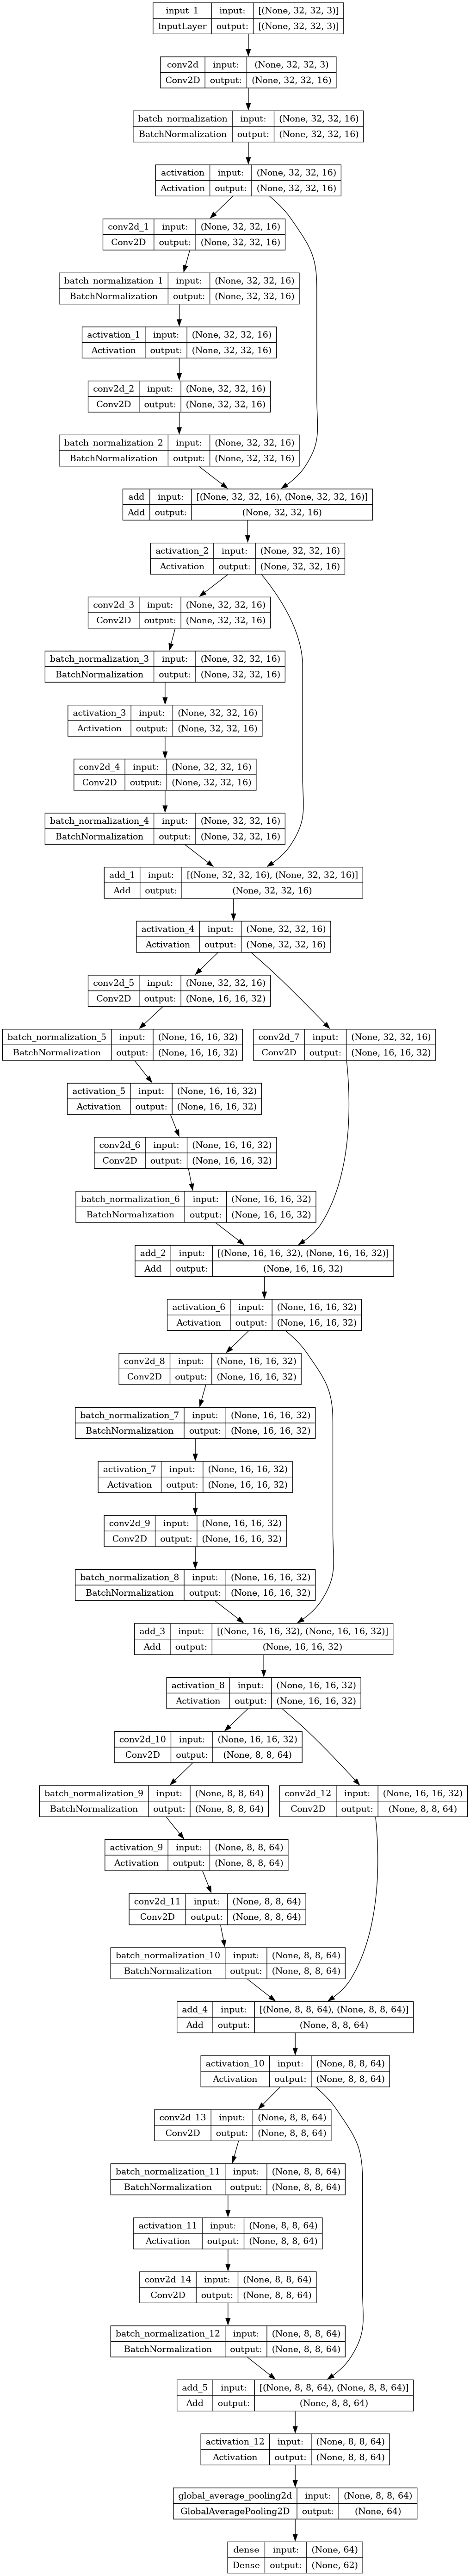

In [12]:
tf.keras.utils.plot_model(light_resnet, "light_resnet.png", show_shapes=True)

paper의 cifar-10 의 구성 내용을 참조해서 만듦

In [28]:
# use same callbacks and optimizer as before

tf.keras.backend.clear_session()

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,
                                                     restore_best_weights=True,verbose=1)
callbacks = [early_stopping_cb]
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, weight_decay=0.0001, momentum=0.9)

light_resnet.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics='accuracy')

history_light = light_resnet.fit(train_data, epochs=10, validation_data=valid_data, batch_size=128, callbacks=callbacks)

Epoch 1/10
17449/17449 [==============================] - 313s 18ms/step - loss: 0.4852 - accuracy: 0.8305 - val_loss: 0.4251 - val_accuracy: 0.8466
Epoch 2/10
17449/17449 [==============================] - 304s 17ms/step - loss: 0.3881 - accuracy: 0.8569 - val_loss: 0.4050 - val_accuracy: 0.8523
Epoch 3/10
17449/17449 [==============================] - 305s 17ms/step - loss: 0.3709 - accuracy: 0.8619 - val_loss: 0.3985 - val_accuracy: 0.8539
Epoch 4/10
17449/17449 [==============================] - 305s 17ms/step - loss: 0.3615 - accuracy: 0.8650 - val_loss: 0.3894 - val_accuracy: 0.8576
Epoch 5/10
17449/17449 [==============================] - 300s 17ms/step - loss: 0.3548 - accuracy: 0.8669 - val_loss: 0.3957 - val_accuracy: 0.8555
Epoch 6/10
17449/17449 [==============================] - 299s 17ms/step - loss: 0.3504 - accuracy: 0.8685 - val_loss: 0.3922 - val_accuracy: 0.8563
Epoch 7/10
17449/17449 [==============================] - 298s 17ms/step - loss: 0.3465 - accuracy: 0.8693

epoch당 800s에서 300s 정도로 단축함
다만 param 수가 23691838 에서 179934, 약 130배 정도 줄었는데 아주 크게 줄어들지는 않은 것 같음

In [30]:
# use adam instead sgd

tf.keras.backend.clear_session()

light_resnet_adam = build_light_resnet50(input_shape, num_classes)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,
                                                     restore_best_weights=True,verbose=1)
rlr = tf.keras.callbacks.ReduceLROnPlateau(verbose=1, mode="auto", factor=0.5)
callbacks = [early_stopping_cb, rlr]
optimizer = tf.keras.optimizers.Adam()

light_resnet_adam.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics='accuracy')

history_light_adam = light_resnet_adam.fit(train_data, epochs=10, validation_data=valid_data, batch_size=128, callbacks=callbacks)

Epoch 1/10
17449/17449 [==============================] - 224s 13ms/step - loss: 0.4935 - accuracy: 0.8317 - val_loss: 0.4168 - val_accuracy: 0.8487 - lr: 0.0010
Epoch 2/10
17449/17449 [==============================] - 214s 12ms/step - loss: 0.3823 - accuracy: 0.8591 - val_loss: 0.3919 - val_accuracy: 0.8563 - lr: 0.0010
Epoch 3/10
17449/17449 [==============================] - 212s 12ms/step - loss: 0.3590 - accuracy: 0.8661 - val_loss: 0.3757 - val_accuracy: 0.8603 - lr: 0.0010
Epoch 4/10
17449/17449 [==============================] - 209s 12ms/step - loss: 0.3447 - accuracy: 0.8703 - val_loss: 0.3706 - val_accuracy: 0.8626 - lr: 0.0010
Epoch 5/10
17449/17449 [==============================] - 213s 12ms/step - loss: 0.3343 - accuracy: 0.8738 - val_loss: 0.3644 - val_accuracy: 0.8659 - lr: 0.0010
Epoch 6/10
17449/17449 [==============================] - 210s 12ms/step - loss: 0.3258 - accuracy: 0.8763 - val_loss: 0.3654 - val_accuracy: 0.8651 - lr: 0.0010
Epoch 7/10
17449/17449 [====

In [31]:
# Nadam

tf.keras.backend.clear_session()

light_resnet_Nadam = build_light_resnet50(input_shape, num_classes)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,
                                                     restore_best_weights=True,verbose=1)
rlr = tf.keras.callbacks.ReduceLROnPlateau(verbose=1, mode="auto", factor=0.5)
callbacks = [early_stopping_cb, rlr]
optimizer = tf.keras.optimizers.Nadam()

light_resnet_Nadam.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics='accuracy')

history_light_Nadam = light_resnet_Nadam.fit(train_data, epochs=10, validation_data=valid_data, batch_size=128, callbacks=callbacks)

Epoch 1/10
17449/17449 [==============================] - 342s 19ms/step - loss: 0.4891 - accuracy: 0.8324 - val_loss: 0.4511 - val_accuracy: 0.8381 - lr: 0.0010
Epoch 2/10
17449/17449 [==============================] - 331s 19ms/step - loss: 0.3824 - accuracy: 0.8596 - val_loss: 0.4229 - val_accuracy: 0.8464 - lr: 0.0010
Epoch 3/10
17449/17449 [==============================] - 337s 19ms/step - loss: 0.3596 - accuracy: 0.8661 - val_loss: 0.3895 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 4/10
17449/17449 [==============================] - 340s 19ms/step - loss: 0.3458 - accuracy: 0.8706 - val_loss: 0.3788 - val_accuracy: 0.8617 - lr: 0.0010
Epoch 5/10
17449/17449 [==============================] - 338s 19ms/step - loss: 0.3355 - accuracy: 0.8738 - val_loss: 0.3696 - val_accuracy: 0.8650 - lr: 0.0010
Epoch 6/10
17449/17449 [==============================] - 332s 19ms/step - loss: 0.3269 - accuracy: 0.8765 - val_loss: 0.3644 - val_accuracy: 0.8673 - lr: 0.0010
Epoch 7/10
17449/17449 [====

In [32]:
# AdamW

tf.keras.backend.clear_session()

light_resnet_adamW = build_light_resnet50(input_shape, num_classes)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,
                                                     restore_best_weights=True,verbose=1)
rlr = tf.keras.callbacks.ReduceLROnPlateau(verbose=1, mode="auto", factor=0.5)
callbacks = [early_stopping_cb, rlr]
optimizer = tf.keras.optimizers.AdamW()

light_resnet_adamW.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics='accuracy')

history_light_adamW = light_resnet_adamW.fit(train_data, epochs=10, validation_data=valid_data, batch_size=128, callbacks=callbacks)

Epoch 1/10
17449/17449 [==============================] - 306s 17ms/step - loss: 0.4951 - accuracy: 0.8306 - val_loss: 0.4115 - val_accuracy: 0.8510 - lr: 0.0010
Epoch 2/10
17449/17449 [==============================] - 354s 20ms/step - loss: 0.3844 - accuracy: 0.8586 - val_loss: 0.3936 - val_accuracy: 0.8565 - lr: 0.0010
Epoch 3/10
17449/17449 [==============================] - 413s 24ms/step - loss: 0.3622 - accuracy: 0.8653 - val_loss: 0.3835 - val_accuracy: 0.8604 - lr: 0.0010
Epoch 4/10
17449/17449 [==============================] - 416s 24ms/step - loss: 0.3488 - accuracy: 0.8694 - val_loss: 0.3699 - val_accuracy: 0.8653 - lr: 0.0010
Epoch 5/10
17449/17449 [==============================] - 355s 20ms/step - loss: 0.3396 - accuracy: 0.8723 - val_loss: 0.3634 - val_accuracy: 0.8668 - lr: 0.0010
Epoch 6/10
17449/17449 [==============================] - 300s 17ms/step - loss: 0.3323 - accuracy: 0.8748 - val_loss: 0.3572 - val_accuracy: 0.8690 - lr: 0.0010
Epoch 7/10
17449/17449 [====

In [33]:
# RMSprop

tf.keras.backend.clear_session()

light_resnet_rms = build_light_resnet50(input_shape, num_classes)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,
                                                     restore_best_weights=True,verbose=1)
rlr = tf.keras.callbacks.ReduceLROnPlateau(verbose=1, mode="auto", factor=0.5)
callbacks = [early_stopping_cb, rlr]
optimizer = tf.keras.optimizers.RMSprop()

light_resnet_rms.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics='accuracy')

history_light_rms = light_resnet_rms.fit(train_data, epochs=10, validation_data=valid_data, batch_size=128, callbacks=callbacks)

Epoch 1/10
17449/17449 [==============================] - 205s 12ms/step - loss: 0.4989 - accuracy: 0.8306 - val_loss: 0.4455 - val_accuracy: 0.8470 - lr: 0.0010
Epoch 2/10
17449/17449 [==============================] - 203s 12ms/step - loss: 0.3973 - accuracy: 0.8572 - val_loss: 0.4006 - val_accuracy: 0.8607 - lr: 0.0010
Epoch 3/10
17449/17449 [==============================] - 204s 12ms/step - loss: 0.3805 - accuracy: 0.8622 - val_loss: 0.4077 - val_accuracy: 0.8611 - lr: 0.0010
Epoch 4/10
17449/17449 [==============================] - 204s 12ms/step - loss: 0.3709 - accuracy: 0.8652 - val_loss: 0.3986 - val_accuracy: 0.8627 - lr: 0.0010
Epoch 5/10
17449/17449 [==============================] - 202s 12ms/step - loss: 0.3635 - accuracy: 0.8675 - val_loss: 0.3905 - val_accuracy: 0.8644 - lr: 0.0010
Epoch 6/10
17449/17449 [==============================] - 202s 12ms/step - loss: 0.3577 - accuracy: 0.8695 - val_loss: 0.3984 - val_accuracy: 0.8642 - lr: 0.0010
Epoch 7/10
17449/17449 [====

### visualize

In [18]:
def plot_history_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'validation'])
    plt.grid(True)
    plt.show()
    
def plot_history_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'validation'])
    plt.grid(True)
    plt.show()

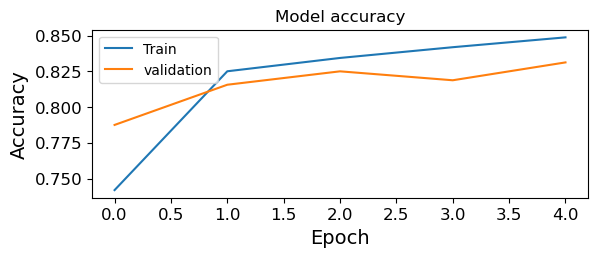

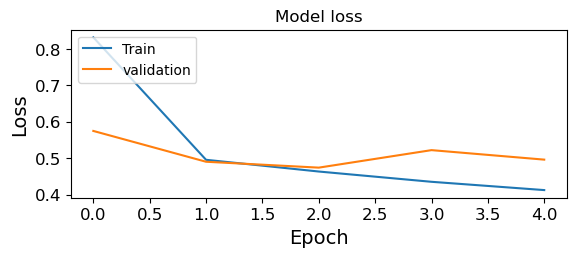

In [23]:
# first model

plt.subplot(211)
plot_history_acc(history)
plt.subplot(212)
plot_history_loss(history)

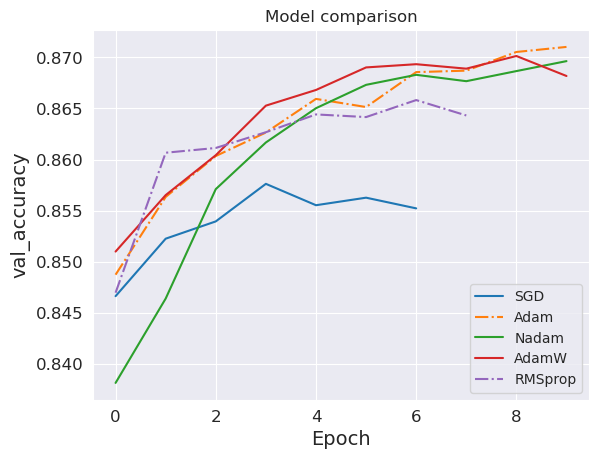

In [56]:
# first model with fixed early stopping
fig,ax=plt.subplots()
plt.plot(history_light.history['val_accuracy'])
plt.plot(history_light_adam.history['val_accuracy'],'-.')
plt.plot(history_light_Nadam.history['val_accuracy'])
plt.plot(history_light_adamW.history['val_accuracy'])
plt.plot(history_light_rms.history['val_accuracy'],'-.')
plt.title('Model comparison')
plt.xlabel('Epoch')
plt.ylabel('val_accuracy')
plt.legend(['SGD','Adam','Nadam','AdamW','RMSprop'],loc='lower right')
plt.grid(True)
plt.show()
# plt.subplot(212)
# plot_history_loss(history_1)

In [ ]:
# comparing with SGD / adam variants

plt.subplot(121)

plt.subplot(122)

## save model

In [20]:
MODEL_PATH = Path() / "models" / "ResNet50"
MODEL_PATH.mkdir(parents=True, exist_ok=True)

In [24]:
resNetv2.save(str(MODEL_PATH) + "/test.keras")

In [21]:
resNetv2_1.save(str(MODEL_PATH) + "/ResnNet50_Original.keras")

## reload model

In [7]:
model = tf.keras.models.load_model(str(MODEL_PATH) + "/test.keras")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # 추가 코드
save_fig("keras_learning_curves_plot")  # 추가 코드
plt.show()

## 참고 문헌
- [ResNet with cifar10 구현](https://github.com/SeHwanJoo/cifar10-ResNet-tensorflow)
- [lr & batch_size 조합](https://inhovation97.tistory.com/32)